In [1]:
# Start Notebook:
%reset -f
import ROOT, numpy, re
import traceback
import sys
import os

# Add the path to sys.path temporarily
script_dir = '/w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis'
sys.path.append(script_dir)
from MyCommonAnalysisFunction_richcap import *
from ExtraAnalysisCodeValues import *
# Now you can remove the path if you wish
sys.path.remove(script_dir)
del script_dir

import math
import array
import copy


def variable_Title_name_new(variable_in):
    if(variable_in in ["k0_cut"]):
        return "E^{Cutoff}_{#gamma}"
    else:
        output = variable_Title_name(variable_in)
        output = output.replace(" (lepton energy loss fraction)", "")
        return output

def find_max_bin(hist):
    max_content = 0
    for bin_ii in range(1, hist.GetNbinsX() + 1):
        bin_content = hist.GetBinContent(bin_ii)
        if(bin_content > max_content):
            max_content = bin_content
    return max_content


ROOT.TH1.AddDirectory(0)
ROOT.gStyle.SetTitleOffset(1.3,'y')

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetOptStat(0)

print(f"{color.BBLUE}\nCode is ready to run.{color.END}\n")


Code is ready to run.



# Valerii's Binning Code

In [2]:
Valerii_binning_params = """
// zpt2phit_8x8x9_binning.cxx
// - Keeps the historical name "zpt2phit_8x8x9" (φ now 8 bins).
// - Restores original pT^2 binning: 10 analysis bins up to 1.0 + overflow 1.0–1.5 (=11 total).
// - Derives N_xq2bins at runtime from makeTH2PolyMars_Valerii().

#include <memory>
#include <vector>
#include <cmath>
#include <stdexcept>
#include <utility>
#include <iostream>

#include "TH2Poly.h"
#include "TH1D.h"
#include "TMath.h"

// -----------------------------------------------------------------------------
// Global binning constants / globals
// -----------------------------------------------------------------------------

static constexpr int N_Zbins  = 8;          // z bins
static constexpr int N_pTbins = 10;         // analysis bins up to 1.0
static constexpr int N_pTbins_with_overflow = N_pTbins + 1; // +1 overflow (1.0–1.5) => 11 total
const int N_phiTrbins = 8;                  // φ bins (Trento) – 8 here
int N_xq2bins = 0;                          // set at runtime from makeTH2PolyMars_Valerii()

// -----------------------------------------------------------------------------
// Forward declarations
// -----------------------------------------------------------------------------
struct bin_xBQ2_Valerii;
struct MarsZpt2;
struct Zpt2Phit_8x8x9;
struct IsEventInBins;

struct BinningContext;

TH2Poly* makeTH2PolyMars_Valerii();
TH2Poly* makeTH2PolyZpt2_Valerii(int xq2, const std::vector<double>& z);
std::vector<double> zbins_Valerii(int xqbin, int nXQ2);

BinningContext make_binning_context();
BinningContext& get_binning_context();

// -----------------------------------------------------------------------------
// Functors
// -----------------------------------------------------------------------------

struct bin_xBQ2_Valerii {
  std::shared_ptr<TH2Poly> poly_xQ2;
  int operator()(double x, double Q2) const {
    return static_cast<int>(poly_xQ2->FindBin(x, Q2));
  }
};

struct MarsZpt2 {
  std::shared_ptr<TH2Poly> poly_xQ2;
  std::shared_ptr<std::vector<std::shared_ptr<TH2Poly>>> poly_zpt2;
  int operator()(double x, double Q2, double z, double pt2) const {
    const int b = static_cast<int>(poly_xQ2->FindBin(x, Q2));
    if (b < 1 || b >= static_cast<int>(poly_zpt2->size())) return -1;
    const auto& h = (*poly_zpt2)[b];
    if (!h) return -1;
    return static_cast<int>(h->FindBin(z, pt2));   // 0 => underflow/out-of-range
  }
};

inline double wrap_phi_deg(double a){
  a = std::fmod(a, 360.0);
  if (a < 0) a += 360.0;
  // Map exact 0 to a tiny positive so 0° goes to first φ-bin instead of underflow
  if (a == 0.0) a = std::nextafter(0.0, 1.0);
  return a;
}

struct Zpt2Phit_8x8x9 {
  MarsZpt2 mars_zpt2;
  std::shared_ptr<TH1D> reft9; // name kept; nbins = N_phiTrbins (8)
  int operator()(double x, double Q2, double z, double pt2, double phit) const {
    const int zpt2 = mars_zpt2(x, Q2, z, pt2);
    if (zpt2 < 1) return -1;

    const double phi_wrapped = wrap_phi_deg(phit);
    const int    nphi = reft9->GetNbinsX();          // 8
    const int    phi  = reft9->FindBin(phi_wrapped); // 1..nphi
    // Composite: φ is fastest
    return (zpt2 - 1)*nphi + phi;                    // 1-based contiguous index
  }
};

struct IsEventInBins {
  std::shared_ptr<TH2Poly> poly_xQ2;
  std::shared_ptr<std::vector<std::shared_ptr<TH2Poly>>> poly_zpt2;
  std::shared_ptr<TH1D> reft9;
  bool operator()(double x, double Q2, double z, double pt2, double phit) const {
    const int b = static_cast<int>(poly_xQ2->FindBin(x, Q2));
    if (b < 1 || b >= static_cast<int>(poly_zpt2->size())) return false;

    const auto& h = (*poly_zpt2)[b];
    if (!h) return false;

    const double phi_wrapped = wrap_phi_deg(phit);
    const int    nphi = reft9->GetNbinsX();
    const int    phi  = reft9->FindBin(phi_wrapped);
    if (phi < 1 || phi > nphi) return false;

    const int zpt2bin = h->FindBin(z, pt2);
    return zpt2bin >= 1;
  }
};

// -----------------------------------------------------------------------------
// Bundle
// -----------------------------------------------------------------------------

struct BinningContext {
  std::shared_ptr<TH2Poly> poly_xQ2;                               // x–Q² mosaic
  std::shared_ptr<std::vector<std::shared_ptr<TH2Poly>>> poly_zpt2; // per-(x,Q²) z⊗pT² mosaics
  std::shared_ptr<TH1D> reft9;                                     // φ bins (8)

  bin_xBQ2_Valerii bin_xBQ2;
  MarsZpt2         mars_zpt2;
  Zpt2Phit_8x8x9   zpt2phit_8x8x9;
  IsEventInBins    isEventInBins;
};

// -----------------------------------------------------------------------------
// Builders
// -----------------------------------------------------------------------------

BinningContext make_binning_context() {
  BinningContext ctx;

  // (x,Q²) poly
  ctx.poly_xQ2 = std::shared_ptr<TH2Poly>(makeTH2PolyMars_Valerii());
  ctx.poly_xQ2->SetDirectory(nullptr);
  (void)ctx.poly_xQ2->FindBin(-1e9, -1e9); // warm-up

  // Derive nXQ2 from the poly and keep it globally available
  const int nXQ2_local = ctx.poly_xQ2->GetNumberOfBins();
  N_xq2bins = nXQ2_local;

  // Per-(x,Q²) z⊗pT² mosaics, allow index 0..nXQ2
  ctx.poly_zpt2 = std::make_shared<std::vector<std::shared_ptr<TH2Poly>>>(nXQ2_local + 1);
  for (int i = 0; i <= nXQ2_local; ++i) {
    auto h = std::shared_ptr<TH2Poly>(makeTH2PolyZpt2_Valerii(i, zbins_Valerii(i, nXQ2_local)));
    h->SetDirectory(nullptr);
    (void)h->FindBin(-1e9, -1e9);
    (*ctx.poly_zpt2)[i] = std::move(h);
  }

  // φ bins (8). Name kept as "reft9" for compatibility.
  ctx.reft9 = std::shared_ptr<TH1D>(new TH1D("reft","",N_phiTrbins,0,360));
  ctx.reft9->SetDirectory(nullptr);

  // Functors
  ctx.bin_xBQ2       = bin_xBQ2_Valerii{ctx.poly_xQ2};
  ctx.mars_zpt2      = MarsZpt2{ctx.poly_xQ2, ctx.poly_zpt2};
  ctx.zpt2phit_8x8x9 = Zpt2Phit_8x8x9{ctx.mars_zpt2, ctx.reft9};
  ctx.isEventInBins  = IsEventInBins{ctx.poly_xQ2, ctx.poly_zpt2, ctx.reft9};
  return ctx;
}

BinningContext& get_binning_context() {
  static BinningContext ctx = make_binning_context();
  return ctx;
}

// -----------------------------------------------------------------------------
// Bins geometry
// -----------------------------------------------------------------------------

// (x,Q²) mosaic (unchanged geometry)
TH2Poly* makeTH2PolyMars_Valerii(){
  auto poly = new TH2Poly();

  // 1st row
  double x1[] = {0.126,  0.18,    0.18,     0.126};
  double y1[] = {2,      2.658,   2,        2};

  double x2[] = {0.18,   0.18,    0.21,     0.21,   0.18};
  double y2[] = {2,      2.658,   2.658,    2,      2};

  double x3[] = {0.21,   0.21,    0.24,     0.24,   0.21};
  double y3[] = {2,      2.658,   2.658,    2,      2};

  double x4[] = {0.24,   0.28,    0.28,     0.24};
  double y4[] = {2.658,  2.658,   2.00,     2};

  // Split 0.28–0.45 into three bins
  double x5_a[] = {0.28,   0.28,    0.34,   0.34};
  double y5_a[] = {2.00,   2.658,   2.658,  2};

  double x5_b[] = {0.34,   0.34,    0.39,   0.39};
  double y5_b[] = {2.00,   2.658,   2.658,  2};

  double x5_c[] = {0.39,   0.39,    0.45,   0.39};
  double y5_c[] = {2.00,   2.658,   2.658,  2};

  // 2nd row
  double x6[] = {0.18,   0.24,    0.24,     0.18};
  double y6[] = {2.658,  3.625,   2.658,    2.658};

  double x7[] = {0.24,   0.24,    0.28,     0.28,   0.24};
  double y7[] = {2.658,  3.625,   3.625,    2.658,  2.658};

  double x8[] = {0.28,   0.28,    0.34,     0.34,   0.28};
  double y8[] = {2.658,  3.625,   3.625,    2.658,  2.658};

  double x9_a[] = {0.34,   0.34,    0.39,  0.39};
  double y9_a[] = {2.658,  3.625,   3.625,    2.658};

  double x9_b[] = {0.39,   0.39,    0.54025,  0.45};
  double y9_b[] = {2.658,  3.625,   3.625,    2.658};

  // 3rd row
  double x10[] = {0.24,  0.34,    0.34,     0.24};
  double y10[] = {3.625, 5.12,    3.625,    3.625};

  double x11[] = {0.34,  0.34,    0.39,     0.39,   0.34};
  double y11[] = {3.625, 5.12,    5.12,     3.625,  3.625};

  double x12[] = {0.39,  0.39,    0.6234,   0.57,   0.54025,  0.39};
  double y12[] = {3.625, 5.12,    5.12,     4.05,   3.625,    3.625};

  // 4th row
  double x13[] = {0.34,  0.677,   0.7896,   0.75,   0.708,    0.64,  0.6234, 0.34};
  double y13[] = {5.12,  10.185,  11.351,   9.52,   7.42,     5.4,   5.12,   5.12};

  // 0-row for bin migration (low Q²)
  double x0_1[] = {0.,   0.,    0.1,  0.1};
  double y0_1[] = {1.5,  2.0,   2.0,  1.5};

  double x0_2[] = {0.1,   0.1,    0.2,  0.2};
  double y0_2[] = {1.5,  2.0,   2.0,   1.5};

  double x0_3[] = {0.2,   0.2,    0.3,  0.3};
  double y0_3[] = {1.5,  2.0,   2.0,   1.5};

  double x0_4[] = {0.3,   0.3,    0.4,  0.4};
  double y0_4[] = {1.5,  2.0,   2.0,   1.5};

  poly->AddBin(4, x1, y1);
  poly->AddBin(5, x2, y2);
  poly->AddBin(5, x3, y3);
  poly->AddBin(4, x4, y4);
  poly->AddBin(4, x5_a, y5_a);
  poly->AddBin(4, x5_b, y5_b);
  poly->AddBin(4, x5_c, y5_c);
  poly->AddBin(4, x6, y6);
  poly->AddBin(5, x7, y7);
  poly->AddBin(5, x8, y8);
  poly->AddBin(4, x9_a, y9_a);
  poly->AddBin(4, x9_b, y9_b);
  poly->AddBin(4, x10, y10);
  poly->AddBin(5, x11, y11);
  poly->AddBin(6, x12, y12);
  poly->AddBin(8, x13, y13);

  // Low Q² bin migration (some may be intentionally empty)
  poly->AddBin(4, x0_1, y0_1);
  poly->AddBin(4, x0_2, y0_2);
  poly->AddBin(4, x0_3, y0_3);
  poly->AddBin(4, x0_4, y0_4);

  poly->SetLineStyle(1);
  poly->SetLineWidth(10);

  return poly;
}

// pT^2 edges per z-bin: 10 analysis bins up to 1.0 + overflow to 1.5 (=> 11 total)
TH2Poly* makeTH2PolyZpt2_Valerii(int /*xq2*/, const std::vector<double>& z){
  // p[i] holds the pT^2 edges for z-bin i (0..N_Zbins-1).
  std::vector<std::vector<double>> p(N_Zbins + 1);

  // Original 10-bin analysis edges up to 1.0:
  const std::vector<double> pt2_base = {
    0.00, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.65, 0.80, 1.00
  }; // 11 edges => 10 bins

  // Fill for all z bins
  for (int z_bin_i = 0; z_bin_i < N_Zbins; ++z_bin_i) p[z_bin_i] = pt2_base;
  p[N_Zbins] = pt2_base;

  // Append overflow edge to 1.5 for each z bin (now 12 edges => 11 bins total)
  for (auto& pi : p) pi.push_back(1.50);

  auto poly = new TH2Poly(); poly->Sumw2();
  poly->SetLineStyle(1);
  poly->SetLineWidth(2);

  // Build z × pT^2 rectangles
  const int NzEdges = static_cast<int>(z.size());
  for (int iz = 0; iz < NzEdges - 1; ++iz) {
    const auto& pz = p[iz]; // pT^2 edges for this z-bin
    for (int j = 0; j < static_cast<int>(pz.size()) - 1; ++j) {
      poly->AddBin(z[iz], pz[j], z[iz+1], pz[j+1]);
    }
  }

  return poly;
}

// Uniform z edges (8 bins => 9 edges)
std::vector<double> zbins_Valerii(int xqbin, int nXQ2){
  if (xqbin < 0 || xqbin > nXQ2)
    throw std::out_of_range("zbins_Valerii: xqbin out of range");
  return {0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0};
}
"""

In [3]:
Valerii_Dataframe = """
using namespace std;

#include "/w/hallb-scshelf2102/clas12/valerii/multiPi0/pass2_v3/source/cuts.cxx"

 // Mars's one:
 //auto poly_mars = makeTH2PolyMars();
double pi_n = TMath::Pi();
//////////////////////////////////////// ANALYSIS: /////////////////////////////////////

// Diffine variables that are the same for data/rec/gen/dis
ROOT::RDF::RNode AddDefine_Kinematics(ROOT::RDF::RNode node)
{

  auto& ctx = get_binning_context();
  
   return node.Define("e_P",                  Get4mom_corr,      {"ex", "ey", "ez", "esec"})
              .Define("e_PT",                                   "return e_P.Pt();")
              .Define("e_mom",                                  "return e_P.P();")
              .Define("e_theta",              theta,            {"e_P"})
              .Define("e_phi",                phi,              {"e_P"})
              //////////////////////////////////////////////////////////////////////
              .Define("q",                    q,                {"e_P"})
              .Define("photon_E",                               "return q.E();")
              .Define("Q2",                   Q2,               {"q"})
              .Define("W2",                   W2,               {"q"})//Mimics others
              .Define("W",                                      "return sqrt(W2);")
              .Define("xB",                   xB,               {"Q2", "q"})
              .Define("y",                    y,                {"q"})//Mimic others
              .Define("gamma",                                  "return 2*m_p*xB / sqrt(Q2);")//Mimics others
              //// Binning: //////////////////
              .Define("bin_xBQ2_Valerii",        ctx.bin_xBQ2,    {"xB", "Q2"});
}

ROOT::RDF::RNode AddDefine_RecDisMC(ROOT::RDF::RNode node)
{
  auto& ctx = get_binning_context();
  
   return node.Define("e_Pm",                  Get4mom_corr,      {"ex_gen", "ey_gen", "ez_gen", "esec"})
              //////////////////////////////////////////////////////////////////////
              .Define("qm",                    q,                {"e_Pm"})
              .Define("Q2m",                   Q2,               {"qm"})
              .Define("W2m",                   W2,               {"qm"})//Mimics others
              .Define("Wm",                                      "return sqrt(W2m);")
              .Define("xBm",                   xB,               {"Q2m", "qm"})
              .Define("ym",                    y,                {"qm"})//Mimic others
              //// Binning: //////////////////
              .Define("bin_xBQ2_Valeriim",        ctx.bin_xBQ2,    {"xBm", "Q2m"});
}



/// Columns for cuts only. They are used in CSB estimation only for now.
ROOT::RDF::RNode AddDefine_CutsCol(ROOT::RDF::RNode node)
{
   return node.Define("strict",            get_cuts_strictness,   {})
              .Define("SF_full",                            "return (e_pcalE + e_ecinE + e_ecoutE)/e_P.P();")
              .Define("SF_pcal_ecin",                            "return (e_pcalE + e_ecinE)/e_P.P();")
              .Define("esec_int",                            "return (int)lrint(esec);")

              //Cuts:
              .Define("cut_pcal_fid_el",       cut_PCAL_fid,        {"e_pcal_Lw", "e_pcal_Lv", "e_pcal_Lu",
                                                                        "e_ecin_Lw", "e_ecin_Lv", "e_ecin_Lu",
                                                                        "e_ecout_Lw", "e_ecout_Lv", "e_ecout_Lu",
                                                                        "esec_int","strict"}) 


              .Define("DC_cut",       cut_DC_edge,        {"e_edge_R1","e_edge_R2","e_edge_R3", "strict"}) 
              .Define("SF_cut",       cut_SF,        {"SF_full","e_mom","esec_int", "strict"});

}
////////////// for Both Data and Rec:
ROOT::RDF::RNode AddDefine_Kinematics_RecData(ROOT::RDF::RNode node)
{

  auto& ctx = get_binning_context();

  
   return node.Define("g1_P",                                 "return (TLorentzVector) {g1x, g1y, g1z, sqrt(g1x*g1x+g1y*g1y+g1z*g1z)};")
              .Define("g1_PT",                                "return g1_P.Pt();")
              .Define("g1_mom",                               "return g1_P.P();")
              .Define("g2_P",                                 "return (TLorentzVector) {g2x, g2y, g2z, sqrt(g2x*g2x+g2y*g2y+g2z*g2z)};")
              .Define("g2_PT",                                "return g2_P.Pt();")
              .Define("g2_mom",                               "return g2_P.P();")
              .Define("pi0_P",                                "return g1_P + g2_P;")
              .Define("pi0_PT",                               "return pi0_P.Pt();")
              .Define("pi0_mom",                              "return pi0_P.P();")
              .Define("pi0_m",                                "return pi0_P.M();")
              .Define("pi0_E",                                "return pi0_P.E();")
              
              .Define("g1_theta",             theta,          {"g1_P"})
              .Define("g1_phi",               phi,            {"g1_P"})
              .Define("g2_theta",             theta,          {"g2_P"})
              .Define("g2_phi",               phi,            {"g2_P"})
              .Define("pi0_theta",            theta,          {"pi0_P"})
              .Define("pi0_phi",              phi,            {"pi0_P"})

              .Define("g_diff_mom",                            "return (g1_mom-g2_mom);")
              .Define("g_rat_mom",                             "return (g1_mom / g2_mom);")
              .Define("g_prod_mom",                            "return (g1_mom * g2_mom);")
              .Define("g_diff_theta",                          "return (g1_theta-g2_theta);")
              .Define("g_diff_phi",                            "return (g1_phi-g2_phi);")
              .Define("g_open_ang",         ang_bet_vec,       {"g1_P", "g2_P"})
              .Define("e_g1_ang",           ang_bet_vec,       {"e_P", "g1_P"})
              .Define("e_g2_ang",           ang_bet_vec,       {"e_P", "g2_P"})
              .Define("e_pi0_ang",          ang_bet_vec,       {"e_P", "pi0_P"})
              .Define("g_E_balance",                           "return (g1_P.E() - g2_P.E())/(g1_P.E() + g2_P.E());")

              .Define("W2_prime",             W2_prime,         {"q", "pi0_P"})
              .Define("W_prime",                                "return sqrt(W2_prime);")
              .Define("z",                                      "return pi0_P.E() / photon_E;")//Mimics others
              .Define("phi_trento",           phi_trento,       {"e_P", "q", "pi0_P"})
              .Define("Mx2",                  Mx2,              {"q", "pi0_P"})
              .Define("Mx",                                     "return sqrt(Mx2);")
              .Define("ele_ang_bet_vec",      ang_bet_vec,      {"e_P", "q"})
              .Define("pi0_rot",              pi0_rotToQ,       {"q","pi0_P"})
              .Define("pi0_sidis_PT",                           "return (pi0_P.Vect()).Perp(q.Vect());")
              .Define("pi0_sidis_PT2",                          "return pow(pi0_sidis_PT, 2);")
              .Define("xF",                   xF,               {"pi0_P", "q", "W2"})//Mimics the definition on the github as of 10/27/2021
  


     

               // Binning
              // I do not think that update is required it return 10*pt bin + z bin. 2 bins are probably overflow. 
              //.Define("zpt2_8x8",               zpt2_8x8,               {"z", "pi0_sidis_PT2"})
              // I am not sure if it is used anywhere so I will keep it at is for now (dec 18 2024)
              //.Define("xq2zpt2_13x8x8",         xq2zpt2_13x8x8,         {"xB", "Q2", "z", "pi0_sidis_PT2"})
              //Valerii: the binning that was actually used. It is a linearization of multidimensional binning
              // Later on Rebin is used to integrate over phitrento
              .Define("zpt2phit_8x8x9",       ctx.zpt2phit_8x8x9,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})
              .Define("isEventINbins",       ctx.isEventInBins,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})

              // I am not sure if those binngs are used anywhere so I will keep it at is for now (dec 18 2024)
              //.Define("xq2zpt2phit_13x8x8x9",   xq2zpt2phit_13x8x8x9,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})
              //.Define("xq2zpt2phit_13x8x8x12",  xq2zpt2phit_13x8x8x12,  {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"});

              //Valerii params for cuts:
              .Define("strict",            get_cuts_strictness,   {})
              .Define("SF_full",                            "return (e_pcalE + e_ecinE + e_ecoutE)/e_P.P();")
              .Define("SF_pcal_ecin",                            "return (e_pcalE + e_ecinE)/e_P.P();")
              .Define("esec_int",                            "return (int)lrint(esec);")
              .Define("g1sec_int",                            "return (int)lrint(g1sec);")
              .Define("g2sec_int",                            "return (int)lrint(g2sec);")

              //Cuts:
              .Define("cut_pcal_fid_el",       cut_PCAL_fid,        {"e_pcal_Lw", "e_pcal_Lv", "e_pcal_Lu",
                                                                        "e_ecin_Lw", "e_ecin_Lv", "e_ecin_Lu",
                                                                        "e_ecout_Lw", "e_ecout_Lv", "e_ecout_Lu",
                                                                        "esec_int","strict"}) 


              .Define("cut_pcal_fid_g1",       cut_PCAL_fid,        {"g1_pcal_Lw", "g1_pcal_Lv", "g1_pcal_Lu",
                                                                        "g1_ecin_Lw", "g1_ecin_Lv", "g1_ecin_Lu",
                                                                        "g1_ecout_Lw", "g1_ecout_Lv", "g1_ecout_Lu",
                                                                        "g1sec_int","strict"}) 
    
              .Define("cut_pcal_fid_g2",       cut_PCAL_fid,        {"g2_pcal_Lw", "g2_pcal_Lv", "g2_pcal_Lu",
                                                                        "g2_ecin_Lw", "g2_ecin_Lv", "g2_ecin_Lu",
                                                                        "g2_ecout_Lw", "g2_ecout_Lv", "g2_ecout_Lu",
                                                                        "g2sec_int","strict"}) 
              .Define("DC_cut",       cut_DC_edge,        {"e_edge_R1","e_edge_R2","e_edge_R3", "strict"}) 
              .Define("SF_cut",       cut_SF,        {"SF_full","e_mom","esec_int", "strict"});

}

////////////// for Gen Only:
ROOT::RDF::RNode AddDefine_Kinematics_GenOnly(ROOT::RDF::RNode node)
{
  auto& ctx = get_binning_context();
   return node
              .Define("pi0_P",                                "return (TLorentzVector) {px, py, pz, sqrt(px*px+py*py+pz*pz+m_pi*m_pi)};")
              .Define("pi0_PT",                               "return pi0_P.Pt();")
              .Define("pi0_mom",                              "return pi0_P.P();")
              .Define("pi0_m",                                "return pi0_P.M();")
              .Define("pi0_E",                                "return pi0_P.E();")
              .Define("pi0_theta",            theta,          {"pi0_P"})
              .Define("pi0_phi",              phi,            {"pi0_P"})
              .Define("z",                                      "return pi0_P.E() / photon_E;")//Mimics others
              .Define("phi_trento",           phi_trento,       {"e_P", "q", "pi0_P"})
              .Define("Mx2",                  Mx2,              {"q", "pi0_P"})
              .Define("Mx",                                     "return sqrt(Mx2);")
              .Define("ele_ang_bet_vec",      ang_bet_vec,      {"e_P", "q"})
              .Define("pi0_rot",              pi0_rotToQ,       {"q","pi0_P"})
              .Define("pi0_sidis_PT",                           "return (pi0_P.Vect()).Perp(q.Vect());")
              .Define("pi0_sidis_PT2",                          "return pow(pi0_sidis_PT, 2);")
              .Define("xF",                   xF,               {"pi0_P", "q", "W2"})//Mimics the definition on the github as of 10/27/2021
              .Define("isEventINbins",       ctx.isEventInBins,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})
              .Define("zpt2phit_8x8x9",       ctx.zpt2phit_8x8x9,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"});
}
////////////// for Rec Only:

ROOT::RDF::RNode AddDefine_Kinematics_RecOnly(ROOT::RDF::RNode node)
{
  auto& ctx = get_binning_context();
  
   return node              //Matching//////////////////////////////////////////////////////////////
              .Define("em_P",                                   "return (TLorentzVector){emx, emy, emz, sqrt(emx*emx+emy*emy+emz*emz + m_e*m_e)};")
              .Define("m1_P",                                   "return (TLorentzVector){g1mx, g1my, g1mz, sqrt(g1mx*g1mx+g1my*g1my+g1mz*g1mz)};")
              .Define("m2_P",                                   "return (TLorentzVector){g2mx, g2my, g2mz, sqrt(g2mx*g2mx+g2my*g2my+g2mz*g2mz)};")
              .Define("pi0_Pm",                                 "return m1_P + m2_P;")
              .Define("pi0_PTm",                                "return pi0_Pm.Pt();")
              .Define("pi0_momm",                               "return pi0_Pm.P();")
              .Define("pi0_mm",                                 "return pi0_Pm.M();")
              .Define("qm",                   q,                {"em_P"})
              .Define("photon_Em",                              "return qm.E();")
              .Define("Q2m",                  Q2,               {"qm"})
              .Define("W2m",                  W2,               {"qm"})//Mimics others
              .Define("W2_primem",            W2_prime,         {"qm", "pi0_Pm"})
              .Define("Wm",                                     "return sqrt(W2m);")
              .Define("W_primem",                               "return sqrt(W2_primem);")
              .Define("xBm",                  xB,               {"Q2m", "qm"})
              .Define("ym",                   y,                {"qm"})//Mimic others
              .Define("zm",                                     "return pi0_P.E() / photon_Em;")//Mimics others
              .Define("gammam",                                 "return 2*0.93827208816*xB / sqrt(Q2m);")//Mimics others
              .Define("phi_trentom",          phi_trento,       {"em_P", "qm", "pi0_Pm"})
              .Define("Mx2m",                 Mx2,              {"qm", "pi0_Pm"})
              .Define("Mxm",                                     "return sqrt(Mx2m);")
              .Define("ele_ang_bet_vecm",     ang_bet_vec,      {"em_P", "qm"})
              .Define("pi0_rotm",             pi0_rotToQ,       {"qm","pi0_Pm"})
              .Define("pi0_sidis_PTm",                          "return (pi0_Pm.Vect()).Perp(qm.Vect());")
              .Define("pi0_sidis_PT2m",                         "return pow(pi0_sidis_PTm, 2);")
              .Define("xFm",                  xF,               {"pi0_Pm", "qm", "W2m"})//Mimics the definition on the github as of 10/27/2021 

              .Define("bin_xBQ2_Valeriim",        ctx.bin_xBQ2,    {"xBm", "Q2m"})

              //.Define("zpt2_8x8m",               zpt2_8x8,               {"zm", "pi0_sidis_PT2m"})
              //.Define("xq2zpt2_13x8x8m",         xq2zpt2_13x8x8,         {"xBm", "Q2m", "zm", "pi0_sidis_PT2m"})
     
               //the one that we need:
              .Define("zpt2phit_8x8x9m",       ctx.zpt2phit_8x8x9,   {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})
              .Define("isEventINbins_m",       ctx.isEventInBins,   {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})
    
              //.Define("xq2zpt2phit_13x8x8x9m",   xq2zpt2phit_13x8x8x9,   {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})
              //.Define("xq2zpt2phit_13x8x8x12m",  xq2zpt2phit_13x8x8x12,  {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})

              .Define("m1_dtheta",                              "return 180.*(g1_P.Theta() - m1_P.Theta())/pi_n;")
              .Define("m2_dtheta",                              "return 180.*(g2_P.Theta() - m2_P.Theta())/pi_n;")
              .Define("m1_dphi",                                "double dphi = g1_P.Phi() - m1_P.Phi(); if (dphi > pi_n){dphi-=2.*pi_n;}  if (dphi < -pi_n){dphi+=2.*pi_n;} return dphi*180.0/pi_n;")
              .Define("m2_dphi",                                "double dphi = g2_P.Phi() - m2_P.Phi(); if (dphi > pi_n){dphi-=2.*pi_n;}  if (dphi < -pi_n){dphi+=2.*pi_n;} return dphi*180.0/pi_n;")
              .Define("m_dtheta_g",                             "return 180.*(m1_P.Theta() - m2_P.Theta())/pi_n;")
              .Define("m_dphi_g",                               "double dphi = m1_P.Phi() - m2_P.Phi(); if (dphi > pi_n){dphi-=2.*pi_n;}  if (dphi < -pi_n){dphi+=2.*pi_n;} return dphi*180.0/pi_n;")
              .Define("m1_dp",                                  "return g1_P.P() - m1_P.P();")
              .Define("m2_dp",                                  "return g2_P.P() - m2_P.P();")
              .Define("m_gmean",                                "return sqrt(g1mVal*g2mVal);")
              .Define("m_gratio",                               "return g1mVal/g2mVal;")
              .Define("nlog_g1mVal",                            "-TMath::Log10(g1mVal);")
              .Define("nlog_g2mVal",                            "-TMath::Log10(g2mVal);")
              .Define("dz",                                     "return z-zm;");
}
////////////// for Unfolding file Only:

/*
ROOT::RDF::RNode AddDefine_Kinematics_UnfOnly(ROOT::RDF::RNode node)
{
   return node//.Define("zpt2_8x8",               zpt2_8x8,               {"z", "pi0_sidis_PT2"})
              //.Define("xq2zpt2_13x8x8",         xq2zpt2_13x8x8,         {"xB", "Q2", "z", "pi0_sidis_PT2"})
              //.Define("zpt2phit_8x8x9",       zpt2phit_8x8x9,   {"z", "pi0_sidis_PT2", "phi_trento"})
              .Define("zpt2phit_8x8x9",       zpt2phit_8x8x9,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})
              .Define("bin_xBQ2_Valerii",        bin_xBQ2_Valerii,    {"xB", "Q2"})

              //.Define("xq2zpt2phit_13x8x8x9",   xq2zpt2phit_13x8x8x9,   {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})
              //.Define("xq2zpt2phit_13x8x8x12",  xq2zpt2phit_13x8x8x12,  {"xB", "Q2", "z", "pi0_sidis_PT2", "phi_trento"})

              //Matching//////////////////////////////////////////////////////////////
              .Define("bin_xBQ2_Valeriim",        bin_xBQ2_Valerii,    {"xBm", "Q2m"})

              //.Define("zpt2_8x8m",               zpt2_8x8,               {"zm", "pi0_sidis_PT2m"})
              //.Define("xq2zpt2_13x8x8m",         xq2zpt2_13x8x8,         {"xBm", "Q2m", "zm", "pi0_sidis_PT2m"})
              //.Define("zpt2phit_8x8x9m",       zpt2phit_8x8x9,   {"zm", "pi0_sidis_PT2m", "phi_trentom"})
              .Define("zpt2phit_8x8x9m",       zpt2phit_8x8x9,   {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})

              //.Define("xq2zpt2phit_13x8x8x9m",   xq2zpt2phit_13x8x8x9,   {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})
    
              //.Define("xq2zpt2phit_13x8x8x12m",  xq2zpt2phit_13x8x8x12,  {"xBm", "Q2m", "zm", "pi0_sidis_PT2m", "phi_trentom"})
              ;
           


}

*/
"""

In [4]:
ROOT.gInterpreter.Declare(r"""
#include <vector>
#include "TH2Poly.h"

static constexpr int N_Zbins  = 8;
static constexpr int N_pTbins = 10;
static constexpr int N_pTbins_with_overflow = N_pTbins + 1;

// (xB, Q2) mosaic (Mars / Valerii)
TH2Poly* makeTH2PolyMars_Valerii_py(){
  auto poly = new TH2Poly();

  // 1st row
  double x1[] = {0.126,  0.18,    0.18,     0.126};
  double y1[] = {2,      2.658,   2,        2};

  double x2[] = {0.18,   0.18,    0.21,     0.21,   0.18};
  double y2[] = {2,      2.658,   2.658,    2,      2};

  double x3[] = {0.21,   0.21,    0.24,     0.24,   0.21};
  double y3[] = {2,      2.658,   2.658,    2,      2};

  double x4[] = {0.24,   0.28,    0.28,     0.24};
  double y4[] = {2.658,  2.658,   2.00,     2};

  // Split 0.28–0.45 into three bins
  double x5_a[] = {0.28,   0.28,    0.34,   0.34};
  double y5_a[] = {2.00,   2.658,   2.658,  2};

  double x5_b[] = {0.34,   0.34,    0.39,   0.39};
  double y5_b[] = {2.00,   2.658,   2.658,  2};

  double x5_c[] = {0.39,   0.39,    0.45,   0.39};
  double y5_c[] = {2.00,   2.658,   2.658,  2};

  // 2nd row
  double x6[] = {0.18,   0.24,    0.24,     0.18};
  double y6[] = {2.658,  3.625,   2.658,    2.658};

  double x7[] = {0.24,   0.24,    0.28,     0.28,   0.24};
  double y7[] = {2.658,  3.625,   3.625,    2.658,  2.658};

  double x8[] = {0.28,   0.28,    0.34,     0.34,   0.28};
  double y8[] = {2.658,  3.625,   3.625,    2.658,  2.658};

  double x9_a[] = {0.34,   0.34,    0.39,  0.39};
  double y9_a[] = {2.658,  3.625,   3.625,    2.658};

  double x9_b[] = {0.39,   0.39,    0.54025,  0.45};
  double y9_b[] = {2.658,  3.625,   3.625,    2.658};

  // 3rd row
  double x10[] = {0.24,  0.34,    0.34,     0.24};
  double y10[] = {3.625, 5.12,    3.625,    3.625};

  double x11[] = {0.34,  0.34,    0.39,     0.39,   0.34};
  double y11[] = {3.625, 5.12,    5.12,     3.625,  3.625};

  double x12[] = {0.39,  0.39,    0.6234,   0.57,   0.54025,  0.39};
  double y12[] = {3.625, 5.12,    5.12,     4.05,   3.625,    3.625};

  // 4th row
  double x13[] = {0.34,  0.677,   0.7896,   0.75,   0.708,    0.64,  0.6234, 0.34};
  double y13[] = {5.12,  10.185,  11.351,   9.52,   7.42,     5.4,   5.12,   5.12};

  // 0-row for bin migration (low Q²)
  double x0_1[] = {0.,   0.,    0.1,  0.1};
  double y0_1[] = {1.5,  2.0,   2.0,  1.5};

  double x0_2[] = {0.1,   0.1,    0.2,  0.2};
  double y0_2[] = {1.5,  2.0,   2.0,   1.5};

  double x0_3[] = {0.2,   0.2,    0.3,  0.3};
  double y0_3[] = {1.5,  2.0,   2.0,   1.5};

  double x0_4[] = {0.3,   0.3,    0.4,  0.4};
  double y0_4[] = {1.5,  2.0,   2.0,   1.5};

  poly->AddBin(4, x1, y1);
  poly->AddBin(5, x2, y2);
  poly->AddBin(5, x3, y3);
  poly->AddBin(4, x4, y4);
  poly->AddBin(4, x5_a, y5_a);
  poly->AddBin(4, x5_b, y5_b);
  poly->AddBin(4, x5_c, y5_c);
  poly->AddBin(4, x6, y6);
  poly->AddBin(5, x7, y7);
  poly->AddBin(5, x8, y8);
  poly->AddBin(4, x9_a, y9_a);
  poly->AddBin(4, x9_b, y9_b);
  poly->AddBin(4, x10, y10);
  poly->AddBin(5, x11, y11);
  poly->AddBin(6, x12, y12);
  poly->AddBin(8, x13, y13);

  // Low Q² migration
  poly->AddBin(4, x0_1, y0_1);
  poly->AddBin(4, x0_2, y0_2);
  poly->AddBin(4, x0_3, y0_3);
  poly->AddBin(4, x0_4, y0_4);

  poly->SetLineStyle(1);
  poly->SetLineWidth(2);

  return poly;
}

// z edges (same as zbins_Valerii)
std::vector<double> zbins_Valerii_py(){
  return {0.,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0};
}

// z × pT^2 mosaic
TH2Poly* makeTH2PolyZpt2_Valerii_py(){
  std::vector<double> z = zbins_Valerii_py();

  std::vector<std::vector<double>> p(N_Zbins + 1);

  const std::vector<double> pt2_base = {
    0.00, 0.05, 0.10, 0.15, 0.20, 0.30, 0.40, 0.50, 0.65, 0.80, 1.00
  }; // 10 bins up to 1.0 => 11 edges

  for(int z_bin_i = 0; z_bin_i < N_Zbins; ++z_bin_i){
    p[z_bin_i] = pt2_base;
  }
  p[N_Zbins] = pt2_base;

  for(auto &pi : p){
    pi.push_back(1.50); // overflow edge => 11 bins total
  }

  auto poly = new TH2Poly();
  poly->Sumw2();
  poly->SetLineStyle(1);
  poly->SetLineWidth(2);

  const int NzEdges = (int)z.size();
  for(int iz = 0; iz < NzEdges - 1; ++iz){
    const auto &pz = p[iz];
    const int nPtEdges = (int)pz.size();
    for(int j = 0; j < nPtEdges - 1; ++j){
      poly->AddBin(z[iz], pz[j], z[iz+1], pz[j+1]);
    }
  }

  return poly;
}

// Singleton getters
TH2Poly* get_valerii_xq2_poly(){
  static TH2Poly* poly = nullptr;
  if(poly == nullptr){
    poly = makeTH2PolyMars_Valerii_py();
  }
  return poly;
}

TH2Poly* get_valerii_zpt2_poly(){
  static TH2Poly* poly = nullptr;
  if(poly == nullptr){
    poly = makeTH2PolyZpt2_Valerii_py();
  }
  return poly;
}

int Q2_xB_bin_valerii(double xB_in, double Q2_in){
  TH2Poly* poly = get_valerii_xq2_poly();
  if(!poly){
    return -1;
  }
  return poly->FindBin(xB_in, Q2_in);
}

int z_pT_bin_valerii(double z_in, double pT_in){
  TH2Poly* poly = get_valerii_zpt2_poly();
  if(!poly){
    return -1;
  }
  const double pt2 = pT_in * pT_in;
  return poly->FindBin(z_in, pt2);
}
""")

print("Done")

Done


In [5]:
def draw_valerii_binning_tlines(pad=None, projection="Q2_vs_xB", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3):
    # pad        : TPad or TCanvas with a 2D histogram already drawn.
    # projection : "Q2_vs_xB", "xB_vs_Q2", "Q2_vs_y", "y_vs_Q2", "z_vs_pT", "pT_vs_z"
    # selected_bin:
    #   - None         -> draw all bin outlines with (line_color, line_width)
    #   - int          -> TH2Poly bin index (1..N_bins) to highlight
    #   - (iz, ipTbin) -> only for z/pT projections, 1-based (z-bin, pT-bin)
    #
    # Returns: list of ROOT.TLine objects that were drawn.
    
    # These are hard-coded from Valerii_binning_params.cxx
    N_ZBINS_VALERII              = 8
    N_PT_BINS_WITH_OVERFLOW_VAL  = 11   # 10 bins up to 1.0 + 1 overflow bin

    # For y calculation:  Constant = 0.5/(0.938272*10.6)
    Y_CONST = (0.5/(0.938272*10.6))

    if(pad is None):
        pad = ROOT.gPad
    if(pad is None):
        raise RuntimeError("draw_valerii_binning_tlines: no pad/canvas and gPad is None.")

    pad.cd()

    proj = str(projection)

    # Decide which TH2Poly we use and initial mapping flags
    if(proj == "Q2_vs_xB"):
        poly      = ROOT.get_valerii_xq2_poly()
        geom_type = "xQ2"    # bins in xB–Q2 space
        swap_axes = False    # draw (xB, Q2)
        use_sqrt  = False
    elif(proj == "xB_vs_Q2"):
        poly      = ROOT.get_valerii_xq2_poly()
        geom_type = "xQ2"
        swap_axes = True     # draw (Q2, xB)
        use_sqrt  = False
    elif(proj == "Q2_vs_y"):
        poly      = ROOT.get_valerii_xq2_poly()
        geom_type = "xQ2_y"  # bins in xB–Q2, but we map xB->y
        swap_axes = False    # draw (y, Q2)
        use_sqrt  = False
    elif(proj == "y_vs_Q2"):
        poly      = ROOT.get_valerii_xq2_poly()
        geom_type = "xQ2_y"
        swap_axes = True     # draw (Q2, y)
        use_sqrt  = False
    elif(proj == "z_vs_pT"):
        poly      = ROOT.get_valerii_zpt2_poly()
        geom_type = "z_pT"   # bins in z–pT^2 space, we will sqrt
        swap_axes = False    # draw (z, pT)
        use_sqrt  = True
    elif(proj == "pT_vs_z"):
        poly      = ROOT.get_valerii_zpt2_poly()
        geom_type = "z_pT"
        swap_axes = True     # draw (pT, z)
        use_sqrt  = True
    else:
        raise ValueError("draw_valerii_binning_tlines: unsupported projection '%s'." % proj)

    if(poly is None):
        raise RuntimeError("draw_valerii_binning_tlines: underlying TH2Poly pointer is null.")

    # For pure xB–Q2 geometry, auto-detect axis orientation only for xB projections
    if((geom_type == "xQ2") and ((proj == "Q2_vs_xB") or (proj == "xB_vs_Q2"))):
        prims = pad.GetListOfPrimitives()
        hist_on_pad = None
        if(prims is not None):
            for obj in prims:
                if(obj.InheritsFrom("TH2")):
                    hist_on_pad = obj
                    break
        if(hist_on_pad is not None):
            xax = hist_on_pad.GetXaxis()
            yax = hist_on_pad.GetYaxis()
            xmin = xax.GetXmin()
            xmax = xax.GetXmax()
            ymin = yax.GetXmin()
            ymax = yax.GetXmax()

            # Rough classification:
            #  - xB range: ~[0, 1]
            #  - Q2 range: ~[1.5, 12]
            x_looks_like_xB = ((xmin >= 0.0) and (xmax <= 1.2))
            y_looks_like_xB = ((ymin >= 0.0) and (ymax <= 1.2))

            if(x_looks_like_xB and (not y_looks_like_xB)):
                swap_axes = False   # (xB,Q2)
            elif((not x_looks_like_xB) and y_looks_like_xB):
                swap_axes = True    # (Q2,xB)
            # else: keep initial guess

    # Build a map: TH2Poly bin number -> TH2PolyBin*
    bins_array = poly.GetBins()
    if(bins_array is None):
        raise RuntimeError("draw_valerii_binning_tlines: TH2Poly::GetBins() returned null.")

    nbins_obj = bins_array.GetEntries()
    binnum_to_binobj = {}

    for idx in range(nbins_obj):
        bin_obj = bins_array.At(idx)
        if(not bin_obj):
            continue
        bin_num = bin_obj.GetBinNumber()
        binnum_to_binobj[bin_num] = bin_obj

    # Map selected_bin -> TH2Poly bin number if needed
    target_bin_number = None

    if(selected_bin is not None):
        if(isinstance(selected_bin, int)):
            target_bin_number = selected_bin
        elif((geom_type == "z_pT") and isinstance(selected_bin, (tuple, list)) and (len(selected_bin) == 2)):
            iz_idx, ipt_idx = selected_bin

            if((iz_idx < 1) or (iz_idx > N_ZBINS_VALERII)):
                raise ValueError("draw_valerii_binning_tlines: z-bin index out of range (1..%d)." % N_ZBINS_VALERII)
            if((ipt_idx < 1) or (ipt_idx > N_PT_BINS_WITH_OVERFLOW_VAL)):
                raise ValueError("draw_valerii_binning_tlines: pT-bin index out of range (1..%d)." % N_PT_BINS_WITH_OVERFLOW_VAL)

            # Same ordering as makeTH2PolyZpt2_Valerii_py: iz outer, pT^2 inner, bins numbered from 1
            target_bin_number = (iz_idx - 1)*N_PT_BINS_WITH_OVERFLOW_VAL + ipt_idx
        else:
            raise TypeError("draw_valerii_binning_tlines: selected_bin must be int or (z_bin, pT_bin) for z/pT projections.")

    # Helper to map one polygon point
    def map_point(x_poly, y_poly):
        # x_poly = xB (for xQ2 / xQ2_y),  y_poly = Q2
        # For z/pT, x_poly = z, y_poly = pT^2

        if(geom_type == "z_pT"):
            # y_poly is pT^2; convert to pT
            if(use_sqrt):
                if(y_poly < 0.0):
                    y_poly = 0.0
                y_val = math.sqrt(y_poly)
            else:
                y_val = y_poly
            x_val = x_poly

            if(swap_axes):
                return (y_val, x_val)
            else:
                return (x_val, y_val)

        elif(geom_type == "xQ2"):
            # Standard xB–Q2 representation
            x_val = x_poly    # xB
            y_val = y_poly    # Q2

            if(swap_axes):
                return (y_val, x_val)   # (Q2,xB)
            else:
                return (x_val, y_val)   # (xB,Q2)

        elif(geom_type == "xQ2_y"):
            # Map (xB,Q2) -> (y,Q2) or (Q2,y)
            xB_val = x_poly
            Q2_val = y_poly

            if(xB_val <= 0.0):
                # Avoid division by zero; put it off-plot if something weird happens
                y_var = -1.0
            else:
                y_var = Y_CONST*(Q2_val/xB_val)

            if(proj == "Q2_vs_y"):
                # x-axis: y,  y-axis: Q2
                return (y_var, Q2_val)
            elif(proj == "y_vs_Q2"):
                # x-axis: Q2, y-axis: y
                return (Q2_val, y_var)
            else:
                # Fallback (should not be reached)
                return (xB_val, Q2_val)

        else:
            # Should not reach here
            return (x_poly, y_poly)

    tlines = []

    # Decide which bin numbers to draw
    if(target_bin_number is not None):
        if(target_bin_number in binnum_to_binobj):
            bin_numbers_to_draw = [target_bin_number]
        else:
            return []
    else:
        bin_numbers_to_draw = sorted(binnum_to_binobj.keys())

    for bin_num in bin_numbers_to_draw:
        bin_obj = binnum_to_binobj[bin_num]
        poly_obj = bin_obj.GetPolygon()
        if(poly_obj is None):
            continue

        gr = poly_obj
        if(not gr.InheritsFrom("TGraph")):
            continue

        npoints = gr.GetN()
        xarr = gr.GetX()
        yarr = gr.GetY()

        for ip in range(npoints):
            jp = ip + 1
            if(jp >= npoints):
                jp = 0

            x0 = xarr[ip]
            y0 = yarr[ip]
            x1 = xarr[jp]
            y1 = yarr[jp]

            xA, yA = map_point(x0, y0)
            xB, yB = map_point(x1, y1)

            line = ROOT.TLine(xA, yA, xB, yB)

            if(target_bin_number is not None):
                line.SetLineColor(highlight_color)
                line.SetLineWidth(highlight_width)
            else:
                line.SetLineColor(line_color)
                line.SetLineWidth(line_width)

            line.Draw("same")
            tlines.append(line)

    # Keep references so the lines are not garbage-collected
    if(not hasattr(pad, "_valerii_binning_tlines")):
        pad._valerii_binning_tlines = []
    pad._valerii_binning_tlines.extend(tlines)

    # Also attach to the pad's primitive list so ROOT owns them
    for line in tlines:
        pad.GetListOfPrimitives().Add(line)

    pad.Modified()
    pad.Update()

    return tlines


print("\nDone\n")


Done



Opened file: /w/hallb-scshelf2102/clas12/richcap/SIDIS_Analysis/Unfolded_Histos_From_Just_RooUnfold_SIDIS_richcap_Lower_Acceptance_Cut_AND_Errors_done_with_kCovToy.root


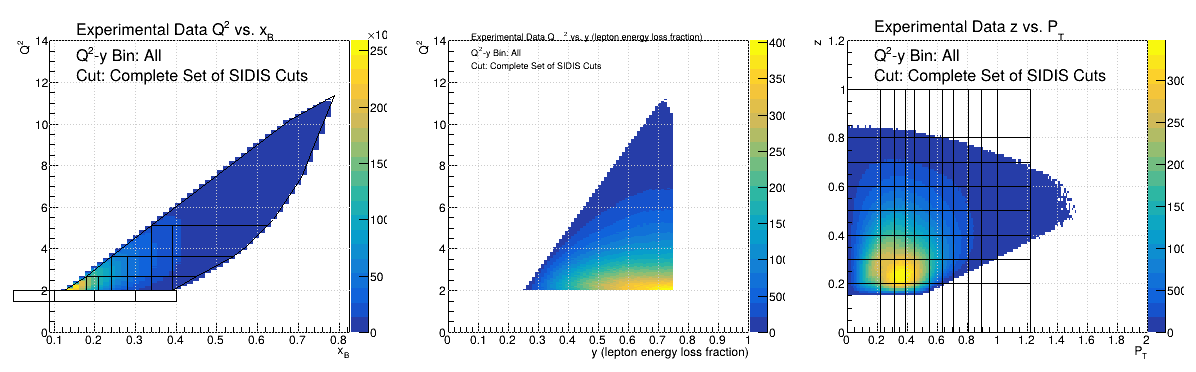

In [6]:
ROOT.gStyle.SetOptStat(0)  # optional: hide stats box


# --------------------------------------------------------------------
# 1. Open the ROOT file (assumed to be in the same directory)
# --------------------------------------------------------------------
file_name = "Unfolded_Histos_From_Just_RooUnfold_SIDIS_richcap_Lower_Acceptance_Cut_AND_Errors_done_with_kCovToy.root"

# If you want to be explicit about the path:
file_path = os.path.join(os.getcwd(), file_name)

root_file = ROOT.TFile.Open(file_path, "READ")
if(not root_file or root_file.IsZombie()):
    raise OSError(f"Could not open ROOT file: {file_path}")
print(f"Opened file: {file_path}")


# --------------------------------------------------------------------
# 2. Helper to build histogram names from your pattern
#
#   (Normal_2D)_(#)_(SMEAR=#)_(Q2_y_Bin_#)_(z_pT_Bin_#)_(Q2)_(xB)
#   (Normal_2D)_(#)_(SMEAR=#)_(Q2_y_Bin_#)_(z_pT_Bin_#)_(Q2)_(y)
#   (Normal_2D)_(#)_(SMEAR=#)_(Q2_y_Bin_#)_(z_pT_Bin_#)_(z)_(pT)
#
# --------------------------------------------------------------------
def build_hist_names(index="rdf", smear="''", q2_y_bin="All", z_pt_bin="All"):
    # Build the three TH2D names corresponding to:
    #   (Q2, xB), (Q2, y), (z, pT)
    # according to your naming convention.
    base = (f"(Normal_2D)_({index})_(SMEAR={smear})_(Q2_y_Bin_{q2_y_bin})_(z_pT_Bin_{z_pt_bin})")

    name_Q2_xB = f"{base}_(Q2)_(xB)"
    name_Q2_y  = f"{base}_(Q2)_(y)"
    name_z_pT  = f"{base}_(z)_(pT)"

    return name_Q2_xB, name_Q2_y, name_z_pT


# --------------------------------------------------------------------
# 3. Function to get histograms and draw them on a divided TCanvas
# --------------------------------------------------------------------
def draw_triplet(index="rdf", smear="''", q2_y_bin="All", z_pt_bin="All", canvas_name="c_triple", canvas_title="Unfolded 2D Histos"):
    # Build the three names
    name_Q2_xB, name_Q2_y, name_z_pT = build_hist_names(index=index, smear=smear, q2_y_bin=q2_y_bin, z_pt_bin=z_pt_bin,)

    # Retrieve histograms as TH3D
    h3_Q2_xB = root_file.Get(name_Q2_xB)
    h3_Q2_y  = root_file.Get(name_Q2_y)
    h3_z_pT  = root_file.Get(name_z_pT)

    # Basic checks on the 3D histograms
    for name, h in [(name_Q2_xB, h3_Q2_xB), (name_Q2_y,  h3_Q2_y), (name_z_pT,  h3_z_pT)]:
        if(not h):
            raise KeyError(f"Histogram not found in file: {name}")
        if(not isinstance(h, ROOT.TH3)):
            raise TypeError(f"Object '{name}' is not a TH3: {type(h)}")

    # Project to TH2D by integrating out the 3rd axis (Z), keep X–Y
    # (Q2,xB), (Q2,y), (z,pT) all assumed to live on the X/Y axes of the TH3D
    h_Q2_xB = h3_Q2_xB.Project3D("yz")
    h_Q2_y  = h3_Q2_y.Project3D("yz")
    h_z_pT  = h3_z_pT.Project3D("yz")
    
    h_Q2_xB.SetTitle(str(h_Q2_xB.GetTitle()).replace("yz projection", ""))
    h_Q2_y.SetTitle(str(h_Q2_y.GetTitle()).replace("yz projection",   ""))
    h_z_pT.SetTitle(str(h_z_pT.GetTitle()).replace("yz projection",   ""))
    # Detach projected histograms from any directory
    for h2 in (h_Q2_xB, h_Q2_y, h_z_pT):
        h2.SetDirectory(0)

    # Create and divide the canvas: 3 pads horizontally
    c = ROOT.TCanvas(canvas_name, canvas_title, 1200, 400)
    c.Divide(3, 1)


    # Pad 1: (Q2, xB)
    c.cd(1)
    h_Q2_xB.Draw("COLZ")
    # Q2_vs_xB_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="Q2_vs_xB", selected_bin=None, draw_all=True, all_color=None, all_style=2, all_width=1, sel_color=None, sel_style=1, sel_width=3)
    # Q2_vs_xB_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="xB_vs_Q2", selected_bin=None, draw_all=True, all_color=None, all_style=2, all_width=1, sel_color=None, sel_style=1, sel_width=3)
    # Q2_vs_xB_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="xB_vs_Q2", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
    Q2_vs_xB_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="xB_vs_Q2", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
    # lines = {}
    # for q2xb in range(1, 17):
    #     Q2_vs_xB_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="xB_vs_Q2", selected_bin=q2xb, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
    #     for num, line in enumerate(Q2_vs_xB_lines):
    #         c.cd(1)
    #         lines[f"Q2_xB_Bin_{q2xb}_{line.GetName()}_{num}"] = line.Clone(f"Q2_xB_Bin_{q2xb}_{line.GetName()}_{num}")
    #         lines[f"Q2_xB_Bin_{q2xb}_{line.GetName()}_{num}"].Draw("same")

    # c.cd(1).Update()

    # Pad 2: (Q2, y)
    c.cd(2)
    h_Q2_y.Draw("COLZ")
    y_vs_Q2_lines = draw_valerii_binning_tlines(pad=c.cd(), projection="y_vs_Q2", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
    # h_Q2_y.SetTitle(f"{name_Q2_y}")

    # Pad 3: (z, pT)
    c.cd(3)
    h_z_pT.Draw("COLZ")
    # z_vs_pT_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="z_vs_pT", selected_bin=None, draw_all=True, all_color=None, all_style=2, all_width=1, sel_color=None, sel_style=1, sel_width=3)
    # z_vs_pT_lines = draw_valerii_binning_tlines(pad=c.cd(1), projection="pT_vs_z", selected_bin=None, draw_all=True, all_color=None, all_style=2, all_width=1, sel_color=None, sel_style=1, sel_width=3)
    z_vs_pT_lines = draw_valerii_binning_tlines(pad=c.cd(3), projection="pT_vs_z", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
    # for line in z_vs_pT_lines:
    #     line.Draw("same")
    # c.Update()
    return c, (h_Q2_xB, h_Q2_y, h_z_pT)


# --------------------------------------------------------------------
# 4. Example usage: fill in the actual values you want
#    for the # placeholders here
# --------------------------------------------------------------------
index_val   = "rdf"      # corresponds to first '#' after Normal_2D
smear_val   = "''"       # corresponds to value in 'SMEAR=#'
q2_y_bin_id = "All"      # corresponds to value in 'Q2_y_Bin_#'
z_pt_bin_id = "All"      # corresponds to value in 'z_pT_Bin_#'

canvas, hists = draw_triplet(index=index_val, smear=smear_val, q2_y_bin=q2_y_bin_id, z_pt_bin=z_pt_bin_id)

canvas.Draw()


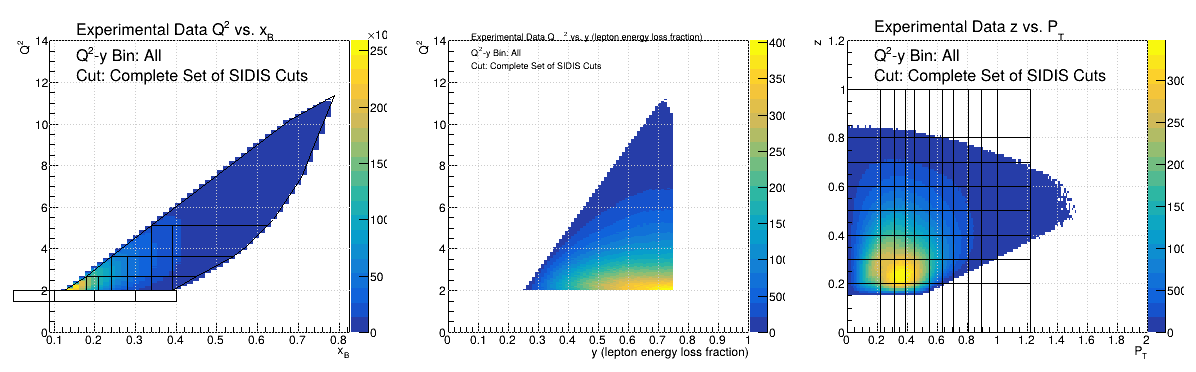

In [7]:
canvas.Draw()


In [13]:
# Number of toy events
n_events = 200000

# Start from an empty RDataFrame with n_events rows
rdf = ROOT.RDataFrame(n_events)

# Define random kinematics:
# - Q2:   1.5 -> 11 GeV^2
# - xB:   0.0 -> 0.8
# - z:    0.0 -> 1.0
# - pT:   0.0 -> 1.25 (so pT^2 up to ~1.56)
rdf = rdf.Define("Q2", "gRandom->Uniform(0.0, 11.0)")
rdf = rdf.Define("xB", "gRandom->Uniform(0.1, 0.8)")
rdf = rdf.Define("z",  "gRandom->Uniform(0.1, 0.9)")
rdf = rdf.Define("pT", "gRandom->Uniform(0.0, 1.25)")
rdf = rdf.Define("phi_t", "gRandom->Uniform(0.0, 360.0)")

def add_valerii_bins(rdf_in, var_type=""):
    xB_col    = f"xB{var_type}"
    Q2_col    = f"Q2{var_type}"
    z_col     = f"z{var_type}"
    pT_col    = f"pT{var_type}"
    phi_t_col = f"phi_t{var_type}"
    
    rdf_tmp =  rdf_in.Define(f"Q2_xB_Bin_Valerii{var_type}", f"Q2_xB_bin_valerii({xB_col}, {Q2_col})")
    rdf_tmp = rdf_tmp.Define(f"z_pT_Bin_Valerii{var_type}",  f"z_pT_bin_valerii({z_col}, {pT_col})")
    
    rdf_tmp = rdf_tmp.Define(f"{phi_t_col}_Bin", f"""
    int Num_PHI_BINS = 24;
    double bin_size  = 360.0/Num_PHI_BINS;
    int PHI_BIN      = (int)({phi_t_col}/bin_size) + 1;
    if({phi_t_col} == 360.0){{PHI_BIN = Num_PHI_BINS;}} // Include 360 in the last phi_h bin
    return PHI_BIN;""")
    
    rdf_tmp = rdf_tmp.Redefine(f"Q2_xB_Bin_Valerii{var_type}", f"""
    if((Q2_xB_Bin_Valerii{var_type} > 16) || (Q2_xB_Bin_Valerii{var_type} < 1)){{
        // There are only 16 physical Q2-xB bins; all other events go to bin 0
        return 0;
    }}
    return Q2_xB_Bin_Valerii{var_type};""")
    
    rdf_tmp = rdf_tmp.Redefine(f"z_pT_Bin_Valerii{var_type}", f"""
    // Original Valerii scheme has 88 z-pT bins (8 z bins × 11 pT^2 bins). I keep only the inner z-bins (iz = 2..7) and pT^2 bins 1..10 for each of them, and reindex those surviving bins to be contiguous from 1..60.
    int bin_old = z_pT_Bin_Valerii{var_type};
    if(bin_old <= 0){{
        return 0;
    }}
    // Decode (z index, pT index) in the original 8×11 layout
    int iz  = (bin_old - 1)/11 + 1; // 1..8
    int ipT = (bin_old - 1)%11 + 1; // 1..11

    // Migration bins in z (iz = 1 or 8) or in pT (ipT = 11) are mapped to 0
    if((iz < 2) || (iz > 7) || (ipT < 1) || (ipT > 10)){{
        return 0;
    }}

    // Compact index: for each of the 6 kept z-bins (iz = 2..7) we have 10 pT bins (ipT = 1..10)
    // New index = ipT + 10*(iz - 2) ∈ [1,60]
    int bin_new = (iz - 2)*10 + ipT;
    return bin_new;""")

    rdf_tmp = rdf_tmp.Define(f"Q2_xB_z_pT_4D_Bin_Valerii{var_type}",  f"""
    if((Q2_xB_Bin_Valerii{var_type} == 0) || (z_pT_Bin_Valerii{var_type} == 0)){{
        return 0;
    }}
    // After compaction there are 60 z-pT bins per physical Q2-xB bin
    int Q2_xB_z_pT_4D_Bin_Valerii_temp = z_pT_Bin_Valerii{var_type} + ((Q2_xB_Bin_Valerii{var_type} - 1) * 60);
    return Q2_xB_z_pT_4D_Bin_Valerii_temp; // Has up to 960+1 total bins 
    """)

    rdf_tmp = rdf_tmp.Define(f"Q2_xB_phi_t_3D_Bin_Valerii{var_type}",  f"""
    if(Q2_xB_Bin_Valerii{var_type} == 0){{
        return 0;
    }}
    int Q2_xB_phi_t_3D_Bin_Valerii_temp = {phi_t_col}_Bin;
    Q2_xB_phi_t_3D_Bin_Valerii_temp = Q2_xB_phi_t_3D_Bin_Valerii_temp + ((Q2_xB_Bin_Valerii{var_type} - 1) * 24);
    return Q2_xB_phi_t_3D_Bin_Valerii_temp; // Has up to 384+1 total bins 
    """)
    
    rdf_tmp = rdf_tmp.Define(f"z_pT_phi_t_3D_Bin_Valerii{var_type}",  f"""
    if(z_pT_Bin_Valerii{var_type} == 0){{
        return 0;
    }}
    int z_pT_phi_t_3D_Bin_Valerii_temp = {phi_t_col}_Bin;
    z_pT_phi_t_3D_Bin_Valerii_temp = z_pT_phi_t_3D_Bin_Valerii_temp + ((z_pT_Bin_Valerii{var_type} - 1) * 24);
    return z_pT_phi_t_3D_Bin_Valerii_temp; // Has up to 1440+1 total bins (60 z-pT × 24 φ-bins)
    """)

    rdf_tmp = rdf_tmp.Define(f"Q2_xB_z_pT_phi_t_5D_Bin_Valerii{var_type}",  f"""
    if((Q2_xB_Bin_Valerii{var_type} == 0) || (z_pT_Bin_Valerii{var_type} == 0)){{
        return 0;
    }}
    int Q2_xB_z_pT_phi_t_5D_Bin_Valerii_temp = {phi_t_col}_Bin + ((Q2_xB_z_pT_4D_Bin_Valerii{var_type} - 1) * 24);
    return Q2_xB_z_pT_phi_t_5D_Bin_Valerii_temp; // Has up to 23040+1 total bins (16 × 60 × 24)
    """)

    return rdf_tmp


rdf_bins = add_valerii_bins(rdf)



print("Created test RDataFrame with columns:", list(rdf_bins.GetColumnNames()))


# Number of z–pT bins
n_zpt_bins = ROOT.get_valerii_zpt2_poly().GetNumberOfBins()
print("Number of Valerii z–pT bins:", n_zpt_bins)

# TH2D: z vs pT for all events
h_z_pT_all = rdf_bins.Histo2D(("h_z_pT_all", "z vs P_{T} (all events); P_{T} [GeV]; z", 800, 0.0, 1.25, 800, 0.0, 1.0), "pT", "z")

# Pick a specific Valerii z–pT bin, for example index 37 (any integer in [1, n_zpt_bins])
selected_zpt_bin = 0

rdf_zpt_sel = rdf_bins.Filter(f"z_pT_Bin_Valerii == {selected_zpt_bin}")
# rdf_zpt_sel = rdf_bins.Filter(f"z_pT_Bin_Valerii != 0")


h_z_pT_sel = rdf_zpt_sel.Histo2D(("h_z_pT_sel", f"z vs P_{{T}} (Valerii bin {selected_zpt_bin}); P_{{T}} [GeV]; z", 800, 0.0, 1.25, 800, 0.0, 1.0), "pT", "z")

c_zpt = ROOT.TCanvas("c_zpt", "z vs pT with Valerii bins", 1200, 500)
c_zpt.Divide(2, 1)

c_zpt.cd(1)
h_z_pT_all.Draw("COLZ")
z_vs_pT_lines = draw_valerii_binning_tlines(pad=c_zpt.cd(1), projection="pT_vs_z", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
z_vs_pT_lines = draw_valerii_binning_tlines(pad=c_zpt.cd(1), projection="pT_vs_z", selected_bin=selected_zpt_bin, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)

c_zpt.cd(2)
h_z_pT_sel.Draw("COLZ")
z_vs_pT_lines = draw_valerii_binning_tlines(pad=c_zpt.cd(2), projection="pT_vs_z", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
z_vs_pT_lines = draw_valerii_binning_tlines(pad=c_zpt.cd(2), projection="pT_vs_z", selected_bin=selected_zpt_bin, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)

c_zpt.Update()

# Number of xB–Q2 bins
n_xq2_bins = ROOT.get_valerii_xq2_poly().GetNumberOfBins()
print("Number of Valerii xB–Q2 bins:", n_xq2_bins)

# TH2D: Q2 vs xB for all events
#   x-axis: Q2
#   y-axis: xB
h_Q2_xB_all = rdf_bins.Histo2D(("h_Q2_xB_all", "x_{B} vs Q^{2} (all events); Q^{2} [GeV^{2}]; x_{B}", 800, 1.5, 11.0, 800, 0.0, 0.8), "Q2", "xB")

# Pick a specific Valerii xB–Q2 bin, for example index 5
# (any integer in [1, n_xq2_bins])
selected_xq2_bin = 0

rdf_xq2_sel = rdf_bins.Filter(f"Q2_xB_Bin_Valerii == {selected_xq2_bin}")
# rdf_xq2_sel = rdf_bins.Filter(f"(Q2_xB_Bin_Valerii > 16 || Q2_xB_Bin_Valerii < 1) && (Q2_xB_Bin_Valerii != 0)")
# rdf_xq2_sel = rdf_bins.Filter(f"Q2_xB_Bin_Valerii != 0")


h_Q2_xB_sel = rdf_xq2_sel.Histo2D(("h_Q2_xB_sel", f"x_{{B}} vs Q^{{2}} (Valerii bin {selected_xq2_bin}); Q^{{2}} [GeV^{{2}}]; x_{{B}}", 800, 1.5, 11.0, 800, 0.0, 0.8), "Q2", "xB")

c_xq2 = ROOT.TCanvas("c_xq2", "Q2 vs xB with Valerii bins", 1200, 500)
c_xq2.Divide(2, 1)

# Pad 1: all events + all bin outlines
c_xq2.cd(1)
h_Q2_xB_all.Draw("COLZ")
Q2_xB_lines_1 = draw_valerii_binning_tlines(pad=c_xq2.cd(1),projection="xB_vs_Q2",selected_bin=None,line_color=ROOT.kBlack,line_width=1,highlight_color=ROOT.kRed,highlight_width=3)
Q2_xB_sel_lines_1 = draw_valerii_binning_tlines(pad=c_xq2.cd(1), projection="xB_vs_Q2", selected_bin=selected_xq2_bin, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)


# Pad 2: only events in the selected Valerii bin + highlighted outline
c_xq2.cd(2)
h_Q2_xB_sel.Draw("COLZ")
Q2_xB_lines_2 = draw_valerii_binning_tlines(pad=c_xq2.cd(2), projection="xB_vs_Q2", selected_bin=None, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)
Q2_xB_sel_lines_2 = draw_valerii_binning_tlines(pad=c_xq2.cd(2), projection="xB_vs_Q2", selected_bin=selected_xq2_bin, line_color=ROOT.kBlack, line_width=1, highlight_color=ROOT.kRed, highlight_width=3)

c_xq2.Update()


Created test RDataFrame with columns: [b'Q2', b'Q2_xB_Bin_Valerii', b'Q2_xB_phi_t_3D_Bin_Valerii', b'Q2_xB_z_pT_4D_Bin_Valerii', b'Q2_xB_z_pT_phi_t_5D_Bin_Valerii', b'pT', b'phi_t', b'phi_t_Bin', b'xB', b'z', b'z_pT_Bin_Valerii', b'z_pT_phi_t_3D_Bin_Valerii']
Number of Valerii z–pT bins: 88
Number of Valerii xB–Q2 bins: 20


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_zpt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_xq2


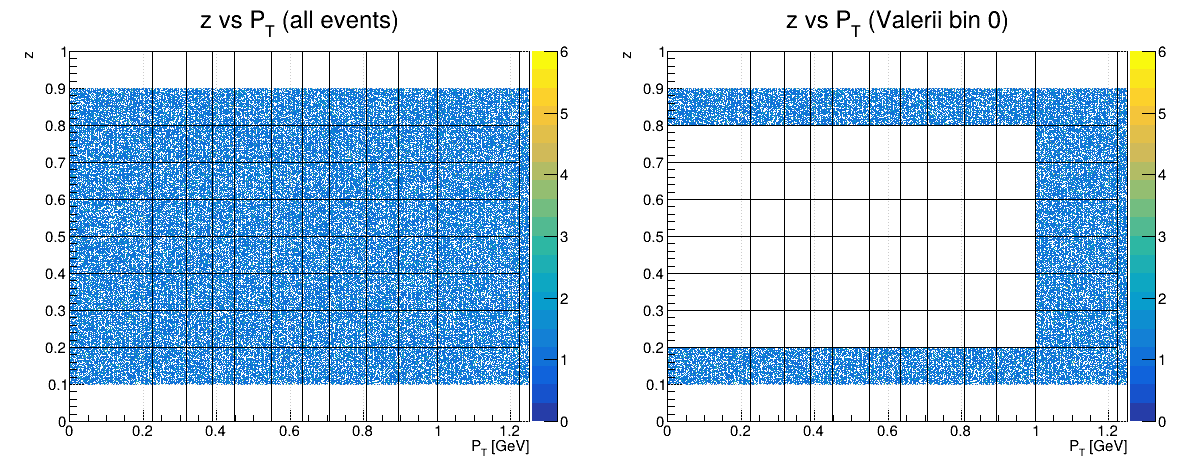

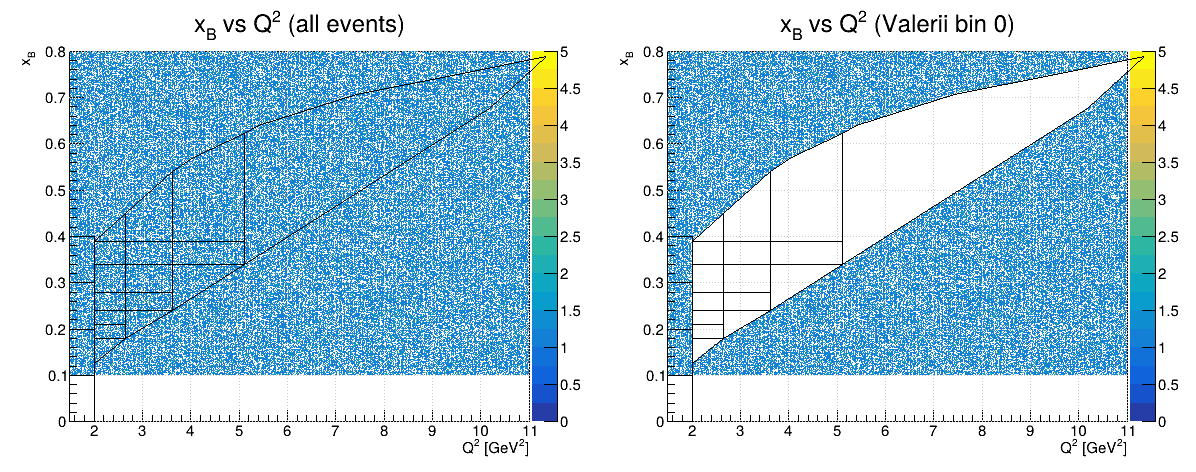

In [9]:
c_zpt.Draw()
c_xq2.Draw()